<a href="https://colab.research.google.com/github/vcautela/Consumo_Energia_TimeSeries/blob/main/ConsumoEnergiaBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('/content/br_mme_consumo_energia_eletrica_uf.csv')

In [3]:
df

,ano,mes,sigla_uf,tipo_consumo,numero_consumidores,consumo
0,2004,1,TO,Total,NaN,65876
1,2004,1,BA,Total,NaN,1444451
2,2004,1,PR,Total,NaN,1596274
3,2004,1,RS,Total,NaN,1780912
4,2004,1,GO,Total,NaN,630624
...,...,...,...,...,...,...
38875,2023,12,BA,Residencial,5932740.0,718461
38876,2023,12,PA,Residencial,2614106.0,478726
38877,2023,12,AC,Residencial,245699.0,58301
38878,2023,12,RN,Residencial,1390080.0,210119


In [4]:
df = df[df['tipo_consumo'] == 'Residencial']
df['tipo_consumo'].unique()

array(['Residencial'], dtype=object)

In [5]:
df['ano'].unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6480 entries, 1620 to 38879
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ano                  6480 non-null   int64  
 1   mes                  6480 non-null   int64  
 2   sigla_uf             6480 non-null   object 
 3   tipo_consumo         6480 non-null   object 
 4   numero_consumidores  6480 non-null   float64
 5   consumo              6480 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 354.4+ KB


In [7]:
#df['data'] = pd.to_datetime(df[['ano', 'mes']].assign(day=1))
df['date'] = pd.to_datetime(df[['ano', 'mes']].assign(day=1).rename(columns={'ano': 'year', 'mes': 'month'}))

<ipython-input-7-70f66b2c5bfb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['ano', 'mes']].assign(day=1).rename(columns={'ano': 'year', 'mes': 'month'}))


In [8]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

<ipython-input-8-6cc74c81a5c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].dt.strftime('%Y-%m-%d')


In [9]:
agg_data_consumo = df.groupby('date')['consumo'].sum()
agg_data_consumo

,consumo
date,
2004-01-01,6780672
2004-02-01,6429231
2004-03-01,6600331
2004-04-01,6808996
2004-05-01,6477331
...,...
2023-08-01,12954936
2023-09-01,13618011
2023-10-01,14337287


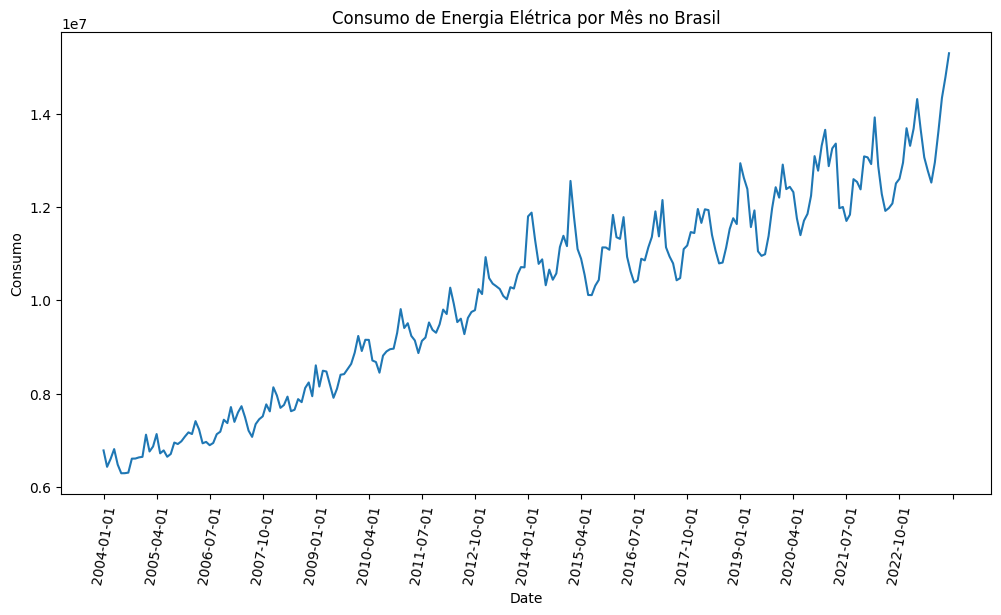

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.xlabel('Date')
plt.ylabel('Consumo')
plt.title('Consumo de Energia Elétrica por Mês no Brasil')

ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Mostra no máximo 10 rótulos no eixo X
plt.xticks(rotation=80)

plt.plot(agg_data_consumo)

Pela visualização do gráfico, podemos observar uma tendencia "uptrend" no consumo de energia, logo concluímos que estamos lidando com dados não estacionários, logo a média não é constante.

In [11]:
# rolling statistics

rolmean = agg_data_consumo.rolling(window=12).mean()
rolstd = agg_data_consumo.rolling(window=12).std()

print(rolmean, rolstd)

date
2004-01-01             NaN
2004-02-01             NaN
2004-03-01             NaN
2004-04-01             NaN
2004-05-01             NaN
                  ...     
2023-08-01    1.316949e+07
2023-09-01    1.326221e+07
2023-10-01    1.340655e+07
2023-11-01    1.355967e+07
2023-12-01    1.369360e+07
Name: consumo, Length: 240, dtype: float64 date
2004-01-01              NaN
2004-02-01              NaN
2004-03-01              NaN
2004-04-01              NaN
2004-05-01              NaN
                  ...      
2023-08-01    566784.824734
2023-09-01    538568.273089
2023-10-01    577199.020788
2023-11-01    679626.289537
2023-12-01    845468.558705
Name: consumo, Length: 240, dtype: float64


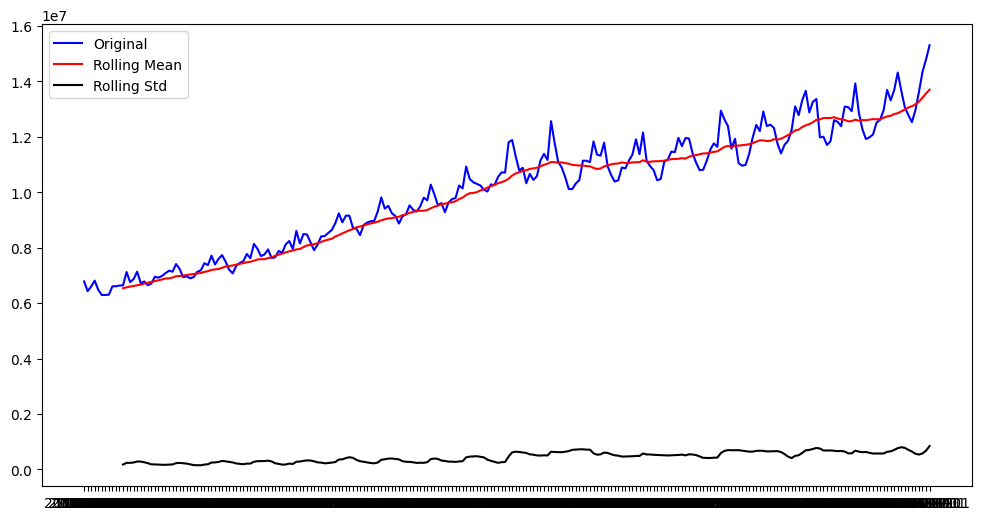

In [12]:
plt.figure(figsize=(12, 6))

orig = plt.plot(agg_data_consumo, color = 'blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend()

Com esse gráfico constatamos que a nem a média e desvio padrão não são constantes.Os dados não são estacionarios


In [13]:
# Dickey-Fuller test:

print('Dickey-Fuller Test:')
df_test = adfuller(agg_data_consumo.values, autolag='AIC')

df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    df_output['Critical Value (%s)'%key] = value
print(df_output)

Dickey-Fuller Test:
Test Statistic                   0.426348
p-value                          0.982454
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


A estatística teste é maior do que todos os valores críticos e temos o P-value muito alto, logo não rejeitamos a hipotese nula. Então concluímos que temos uma série temporal Não estacionária.

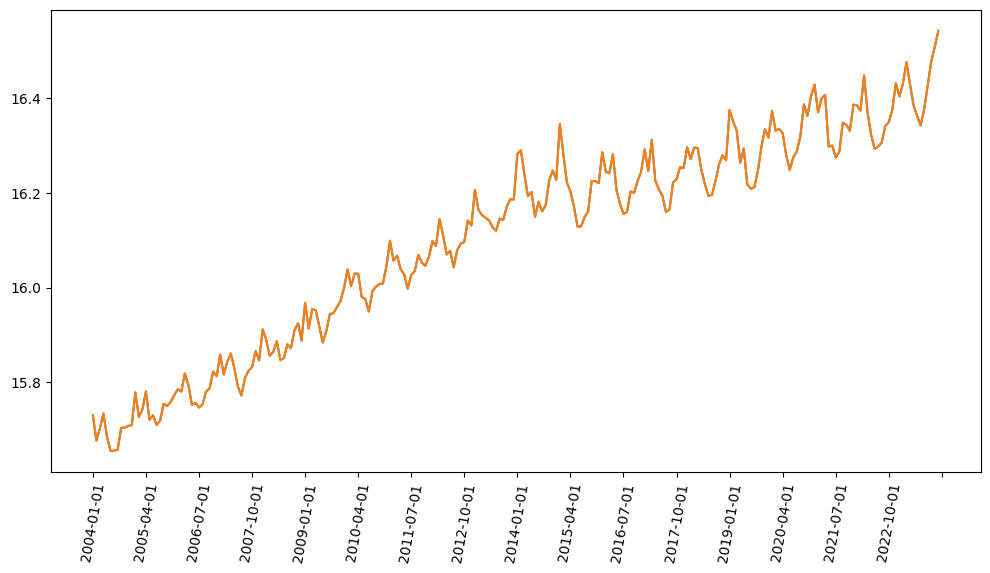

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

agg_data_consumo_logScale = np.log(agg_data_consumo)
plt.plot(agg_data_consumo_logScale)

ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Mostra no máximo 10 rótulos no eixo X
plt.xticks(rotation=80)

plt.plot(agg_data_consumo_logScale)

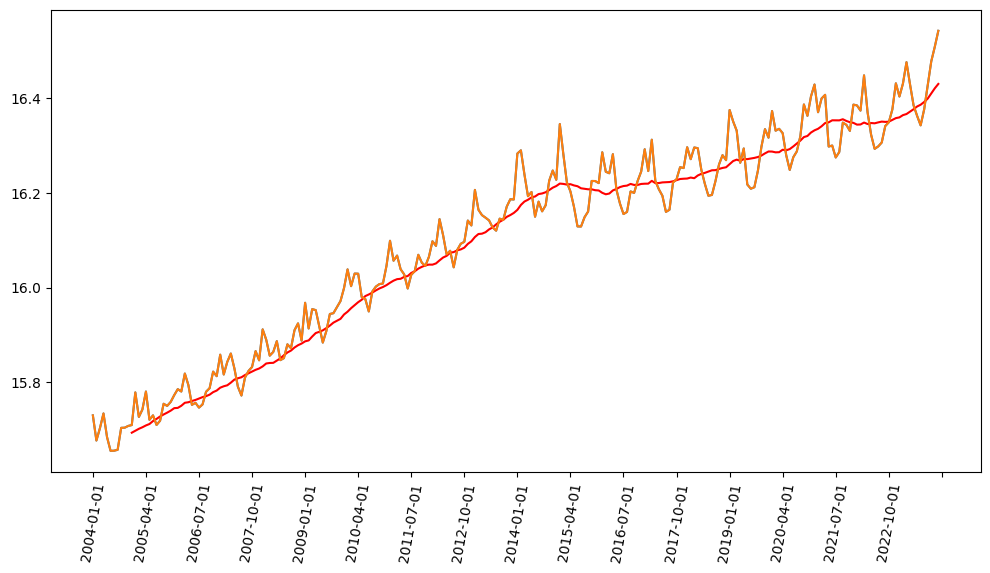

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

movingAverage = agg_data_consumo_logScale.rolling(window=12).mean()
movingSTD = agg_data_consumo_logScale.rolling(window=12).std()

ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Mostra no máximo 10 rótulos no eixo X
plt.xticks(rotation=80)

plt.plot(agg_data_consumo_logScale)
plt.plot(movingAverage, color='red')

plt.plot(agg_data_consumo_logScale)

difference between moving avg and actual consumption





In [16]:
datasetLogScaleMinusMovingAverage = agg_data_consumo_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

,consumo
date,
2004-01-01,NaN
2004-02-01,NaN
2004-03-01,NaN
2004-04-01,NaN
2004-05-01,NaN
2004-06-01,NaN
2004-07-01,NaN
2004-08-01,NaN
2004-09-01,NaN


In [17]:
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,consumo
date,
2004-12-01,0.016157
2005-01-01,0.081187
2005-02-01,0.025101
2005-03-01,0.037514
2005-04-01,0.071742
2005-05-01,0.008958
2005-06-01,0.012058
2005-07-01,-0.012810
2005-08-01,-0.008971


In [18]:
def test_stationarity(timeseries):

  # determining rolling statistics
  movingAverage = timeseries.rolling(window=12).mean()
  movingSTD = timeseries.rolling(window=12).std()

  # plot rolling stat
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Mostra no máximo 10 rótulos no eixo X
  plt.xticks(rotation=80)
  orig = plt.plot(agg_data_consumo, color = 'blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  # perform dickey fuller test
  print('Result of Dickey-Fuller Test:')
  dftest = adfuller(timeseries.values, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)



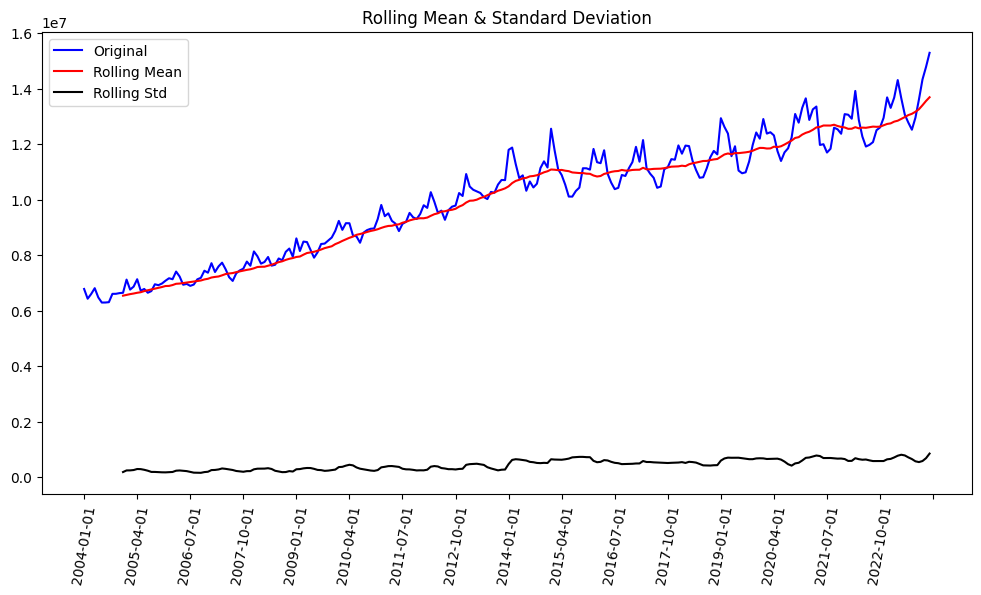

Result of Dickey-Fuller Test:
Test Statistic                  -2.734475
p-value                          0.068260
#Lags Used                      15.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [19]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Ainda é possível observar um uptrend no gráfico indicando que meu dataset ainda não é estacionário. Porém, é possível comparar as estatisticas anteriores e perceber uma melhoria, com uma grande diminuição do p-value e podemos observar o teste estatístico com um valor inferior ao Critical Value (10%), dessa forma podemos "rejeitar" a hipótese nula para o nível de significancia de 10%.

concluímos que para níveis de significancia iguais ou abaixo de 5%, não temos evidencias suficiente para rejeitar a hipótese nula (Os dados NÃO são estacionários)

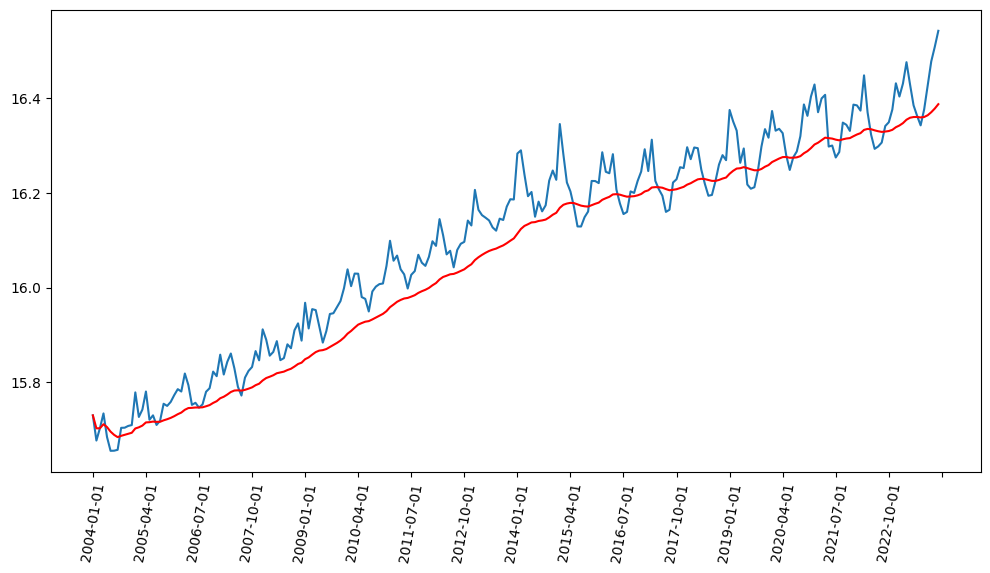

In [20]:
exponentialDecayWeightedAverage = agg_data_consumo_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
fig, ax = plt.subplots(figsize=(12, 6))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))  # Mostra no máximo 10 rótulos no eixo X
plt.xticks(rotation=80)
plt.plot(agg_data_consumo_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

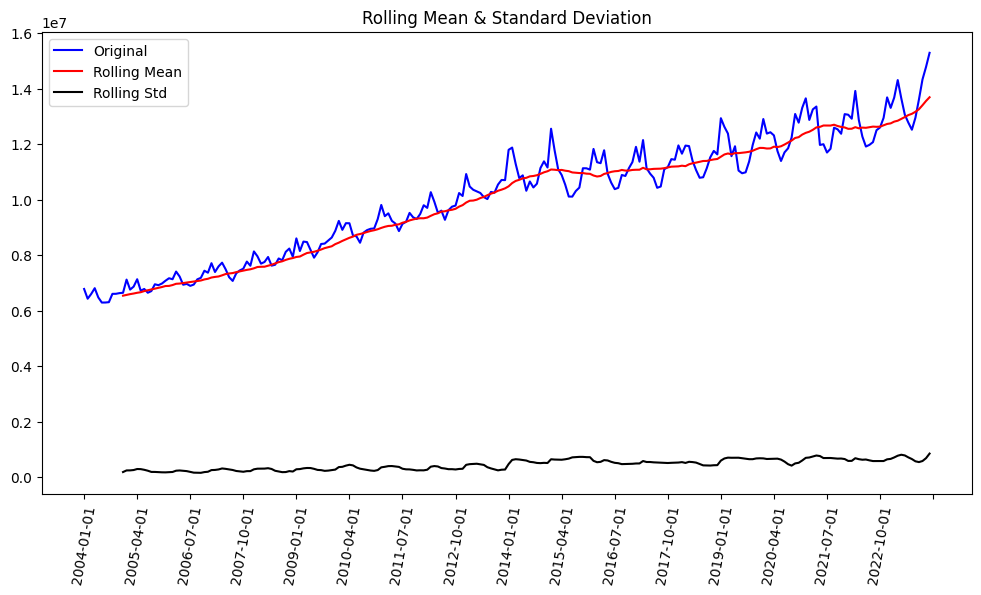

Result of Dickey-Fuller Test:
Test Statistic                  -1.922779
p-value                          0.321422
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [21]:
datasetLogScaleMinusMovingExponentialDecayAverage = agg_data_consumo_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

testamos suavisar os dados temporais a partir da standard moving average(SMA) e em seguida com exponentially weighted moving average(EWMA). Percebe-se uma melhor performance com a SMA